<h1 style="font-size: 40px; margin-bottom: 0px;">13.2 Functional analysis of RNA-seq results</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 950px;"></hr>

Yesterday, we explored our data at the level of each gene. Today, we'll take a look at our data with respect to groups of genes through a functional analysis of our differential expression results. While looking at the changes in expression of individual genes can provide insight into the gene-level impacts of experimental manipulations, we can also look for groups of genes that change together through functional analysis. This type of analysis can give us insight into broader biological changes that are occurring as a result of experimental manipulations, such as knocking down TAZ. So rather than asking about what is happening to a specific gene, we are instead asking about what biological processes, signaling pathways, or other functional groups are changing in our cells.

<strong>Learning objectives:</strong>

<ul>
    <li>Explore databases for functional analysis</li>
    <li>Review and perform an over-representation analysis</li>
    <li>Review and perform gene set enrichment analysis (GSEA)</li>
    <li>Explore other programs and methods to perform functional analysis</li>
</ul>

<h1>Install GSEApy and load in packages</h1>

We'll be performing both the over-representation analysis and GSEA using Python, and to do this, we'll make use of a package called <code>GSEApy</code>, which was developed by Zhuoqing Fang, Xinyuan Liu, and Gary Peltz (<a href="https://academic.oup.com/bioinformatics/article/39/1/btac757/6847088" rel="noopener noreferrer" target="_blank"><u>Fang et al 2022</u></a>). It also allows us to directly pull into our notebook, a bunch of different databases all containing their own gene sets, which we can then use to identify functional groups that may be impacted when we knocked down TAZ.

<a href="https://gseapy.readthedocs.io/en/latest/index.html" rel="noopener noreferrer" target="_blank"><u>Documentation for GSEApy package can be found here.</u></a>

First, we'll install GSEApy:

In [1]:
pip install gseapy

  Using cached gseapy-1.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (548 kB)
Note: you may need to restart the kernel to use updated packages.


Then we'll load in the packages we'll use for today's lesson.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
import networkx as nx

<h1>Explore databases</h1>

Recall from Dr. Ingolia's lecture that there are a large number of different databases curated by different organizations and people. Each database will group genes a little differently depending on their own classification scheme, and so selecting a database can affect how you interpret your functional analysis. Some may allow you to gain insight into the regulation of different pathways and others may provide information on how biological processes are altered in your experimental manipulation.

Let's briefly take some time to take a look at some databases to see how they organize their gene sets.

<h2>Pull in Molecular Signatures Database (MSigDB)</h2>

One of the major databases is the <a href="https://www.gsea-msigdb.org/gsea/msigdb" rel="noopener noreferrer" target="_blank"><u>Molecular Signatures Database (MSigDB)</u></a>, which contains annotated gene sets for functional analysis. MSigDB is a joint project between UC San Diego and the Broad Institute (<a href="https://www.pnas.org/doi/10.1073/pnas.0506580102" rel="noopener norferrer" target="_blank"><u>Subramanian, Tamayo et al 2005</u></a>, <a href="https://pmc.ncbi.nlm.nih.gov/articles/PMC4707969/" rel="noopener norferrer" target="_blank"><u>Liberzon et al 2015</u></a>) and funded by the National Cancer Institute's Informatics Technology for Cancer Research.

GSEApy allows us to pull in information on the current <a href="https://data.broadinstitute.org/gsea-msigdb/msigdb/release/" rel="noopener noreferrer" target="_blank"><u>MSigDB database from the Broad Institute.</u></a>

To do this, we'll make use of the <code>gp.Msigdb()</code> function from the GSEApy package.

```
msig = gp.Msigdb()
```

In [3]:
msig = gp.Msigdb()

In [4]:
msig

We can then take a look to see what directories the server currently has:

```
msig.list_dbver()
```

In [5]:
msig.list_dbver()

,Name,Last modified
0,6.0,2018-12-17 16:29
1,6.1,2018-12-17 16:29
2,6.2,2018-12-17 16:29
3,7.0,2020-01-27 04:43
4,7.1,2020-03-30 16:55
5,7.2,2020-09-18 23:33
6,7.3,2021-03-22 15:09
7,7.4,2021-04-02 14:38
8,7.5.1,2023-03-09 19:38
9,7.5,2022-01-13 01:00


To get the <code>gmt</code> file, we will make use of the function <code>msig.get_gmt()</code>, where <code>msig</code> is the <code>msigdb</code> object that we created earlier with the <code>Msigdb()</code> function.

```
hallmark_db = msig.get_gmt(category='h.all', dbver='2024.1.Hs')
```

Let's break down this line of code:

<code>hallmark_db</code>

This is the variable that we will save our database. The database is imported into Python as a <code>dict</code> (dictionary) object, so it has <code>key:value</code> pairs, where the key is the category or group that a gene or genes belong to, and the value is the gene name. 

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&equals;</code>

Our assignment operator.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>msig.get_gmt()</code>

This function allows us to pull in the database that we want to use for our functional analysis. The files are usually in a <a href="https://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/Data_formats#GMT:_Gene_Matrix_Transposed_file_format_.28.2A.gmt.29" rel="noopener noreferrer" target="_blank"><u>.gmt (Gene Matrix Transposed) format</u></a>.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>category='h.all'</code>

This is the database that we want to pull in, since if we take a look at the directory, it contains a bunch of different .gmt files. Here, we're pulling in the MSigDB Hallmark database.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>dbver='2024.1.Hs'</code>

This is the database version that we're pulling in. As you saw when we took a look at the <code>msigdb</code> object, there were different versions of the MSigDB for both humans and mice, and the <code>dbver</code> parameter allows us to select which version we want to pull into our notebook.

Let's input the code into the code cell below:

In [6]:
hallmark_db = msig.get_gmt(category='h.all', dbver='2024.1.Hs')

In [7]:
type(hallmark_db)

dict

Since the object is a dictionary, we can pull all the values associated with a specific key. In other words, pull all the genes associated with a specific MSigDB Hallmark category.

```
hallmark_db['HALLMARK_ADIPOGENESIS']
```

In [ ]:
hallmark_db['HALLMARK_ADIPOGENESIS']

What you should see is a list of genes that have been categorized as being involved in adipogenesis by MSigDB. We can also take a look at the whole database by converting the dictionary to a DataFrame:

```
pd.DataFrame.from_dict(hallmark_db, orient='index').T
```

Since we're not saving it to a variable, this is just for us to take a look at the different gene sets in the database we pulled in.

In [9]:
pd.DataFrame.from_dict(hallmark_db, orient='index').T

,HALLMARK_ADIPOGENESIS,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANGIOGENESIS,HALLMARK_APICAL_JUNCTION,HALLMARK_APICAL_SURFACE,HALLMARK_APOPTOSIS,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_COAGULATION,...,HALLMARK_PROTEIN_SECRETION,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,HALLMARK_SPERMATOGENESIS,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_UP,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_XENOBIOTIC_METABOLISM
0,ABCA1,AARS1,ABCC4,APOH,ACTA1,ADAM10,ADD1,ABCA1,ABCA2,A2M,...,ABCA1,ABCC1,ACE,ACVR1,ABCA1,ALDH18A1,ABCC1,ABCB1,ADAM17,ABCC2
1,ABCB8,ABCE1,ABHD2,APP,ACTB,ADIPOR2,AIFM3,ABCA2,ACAT2,ACOX2,...,ADAM10,ATOX1,ACRBP,APC,ACKR3,ARFGAP1,ACVR2A,ACAA1,AXIN1,ABCC3
2,ACAA2,ABI1,ACSL3,CCND2,ACTC1,AFAP1L2,ANKH,ABCA3,ACSS2,ADAM9,...,ANP32E,CAT,ACRV1,ARID4B,AREG,ASNS,ADD3,AGO2,AXIN2,ABCD2
3,ACADL,ACHE,ACTN1,COL3A1,ACTG1,AKAP7,ANXA1,ABCA4,ACTG1,ANG,...,AP1G1,CDKN2D,ACTL7B,BCAR3,ATF3,ATF3,ADGRL2,ALAS1,CCND2,ABHD6
4,ACADM,ACVR2A,ADAMTS1,COL5A2,ACTG2,APP,APP,ABCA5,ADH4,ANXA1,...,AP2B1,EGLN2,ADAD1,BMP2,ATP2B1,ATF4,ADORA2B,ALDOA,CSNK1E,ACO2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,UQCR11,UBE2D1,None,None,VWF,None,None,None,None,None,...,None,None,None,None,VEGFA,None,None,None,None,UPB1
196,UQCRC1,UBE2N,None,None,WASL,None,None,None,None,None,...,None,None,None,None,YRDC,None,None,None,None,UPP1
197,UQCRQ,WARS1,None,None,WNK4,None,None,None,None,None,...,None,None,None,None,ZBTB10,None,None,None,None,VNN1
198,VEGFB,WAS,None,None,YWHAH,None,None,None,None,None,...,None,None,None,None,ZC3H12A,None,None,None,None,VTN


For this version of the MSigDB Hallmark human database, you can see that there are 50 different categories ranging from adipogenesis to xenobiotic metabolism with varying numbers of genes inside of them. <a href="https://www.gsea-msigdb.org/gsea/msigdb/human/genesets.jsp?collection=H" rel="noopener noreferrer" target="_blank"><u>We can also find more information on these gene sets by diving into the MSigDB page on their Hallmark database.</u></a>

<h2>Use GSEApy to pull Enrichr library of databases</h2>

GSEApy also functions as an Enrichr wrapper, meaning that it allows you to use the Enrichr web program through Python. <a href="https://maayanlab.cloud/Enrichr/" rel="noopener noreferrer" target="_blank"><u>Enrichr is developed and maintained by the Ma'ayan lab at the Icahn School of Medicine, Mount Sinai, Center for Bioinformatics</u></a> (<a href="https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-128" rel="noopener noreferrer" target="_blank"><u>Chen et al 2013</u></a>), and it's one of many web-based tools/programs that allow you to perform functional analyses, such as the ones we're doing in this lesson.

To take a look at what human-specific databases we can work with for functional analysis, we can make use of the <code>gp.get_library_name()</code> function.

```
databases = gp.get_library_name(organism='Human')
```

In [10]:
databases = gp.get_library_name(organism='Human')

Let's take a look at what we pulled into our notebook

In [ ]:
databases

You should see that we now have a long list of different human-specific databases that have categorized genes in a variety of different ways.

Some commonly used ones that Dr. Ingolia mentioned in lecture are those databases from the <a href="https://geneontology.org/" rel="noopener noreferrer" target="_blank"><u>Gene Ontology (GO) resource</u></a>, the MSigDB, and the <a href="https://www.genome.jp/kegg/" rel="noopener noreferrer" target="_blank"><u>Kyoto Encyclopedia of Genes and Genomes (KEGG)</u></a>. Recall that GO is at the highest level of grouping, divided into three major categories: biological process, cell component, and molecular function, and you should be able to see in this list of databases, these three categories as their own database for functional analysis.

Note that these are pulled from the Enrichr library, and that they might not always be the most up-to-date. Note the date for their repository of the MSigDB Hallmark database, <code>MSigDB_Hallmark_2020</code>, while we can directly download or pull the most up-to-date version directly from MSigDB.

<h2>Using databases</h2>

These databases often can be used through web or desktop programs that have been developed, and we'll explore some of them towards the end of this lesson if we have time.

To use these databases via GSEApy, we can just pass the name or the variable for the gene set that we want to use for our functional analysis.

<h1>Load in and prepare data</h1>

Let's go ahead and load in our RNA-seq data that we'll use for today's lesson:

<ul>
    <li>Our normalized counts matrix</li>
    <li>Our shrunken log fold change results</li>
</ul>

In [12]:
norm_counts = pd.read_csv('/home/jovyan/MCB201B_F2024/Week_13/data/1M_norm_counts.csv', delimiter=',')
shrinklfc = pd.read_csv('/home/jovyan/MCB201B_F2024/Week_13/data/1M_results_lfcShrink.csv', delimiter=',')

Let's take a look at our imported data.

In [13]:
norm_counts

,Unnamed: 0,ctrl_g1,taz_g1,ctrl_g2,taz_g2,ctrl_g3,taz_g3,ctrl_g4,taz_g4,ctrl_g5,taz_g5,ctrl_g6,taz_g6,ctrl_g7,taz_g7,ctrl_g8,taz_g8
0,A1BG,0.000000,1.909227,0.984459,5.567589,0.000000,0.984725,0.978265,1.932920,0.935575,0.917749,0.000000,0.000000,1.061338,1.060735,0.000000,1.030151
1,A1BG-AS1,2.964164,1.909227,1.968918,1.855863,3.909410,2.954176,1.956530,0.966460,0.935575,0.917749,1.984798,2.016977,1.061338,0.000000,3.092942,0.000000
2,A2M,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.061338,0.000000,0.000000,0.000000
3,A2M-AS1,0.000000,0.000000,2.953377,0.000000,0.977352,0.000000,0.000000,0.000000,0.935575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,A4GALT,11.856654,8.591522,6.891213,18.558630,6.841467,11.816703,7.826119,7.731681,3.742300,9.177489,12.901190,13.110351,7.429369,13.789553,10.309807,9.271357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18091,ZYG11A,4.940273,8.591522,2.953377,7.423452,12.705582,13.786154,5.869589,6.765221,2.806725,9.177489,8.931593,8.067909,7.429369,4.242939,5.154903,5.150754
18092,ZYG11B,31.617745,52.503746,32.487149,29.693808,30.297925,39.389011,60.652422,49.289468,41.165302,50.476192,45.650365,50.424428,36.085505,42.429394,35.053344,49.447240
18093,ZYX,115.602379,126.008991,125.026299,103.928327,73.301433,97.487802,83.152514,115.008759,96.364229,111.047623,129.011901,129.086537,80.661717,114.559365,88.664340,110.226138
18094,ZZEF1,31.617745,34.366088,43.316198,26.910013,31.275278,35.450110,37.174065,29.960265,32.745126,44.969698,42.673167,27.229191,28.656136,48.793804,55.672957,31.934676


In [14]:
shrinklfc

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj
0,A1BG,1.085171,0.211319,0.392672,0.071757,0.199049
1,A1BG-AS1,1.780883,-0.142668,0.317841,0.273008,0.489257
2,A2M,0.066334,-0.017169,0.310137,0.901389,NaN
3,A2M-AS1,0.304144,-0.069617,0.319293,0.332131,NaN
4,A4GALT,9.990338,0.269608,0.258235,0.130600,0.303393
...,...,...,...,...,...,...
18091,ZYG11A,7.124803,0.149665,0.255240,0.360801,0.580910
18092,ZYG11B,42.291440,0.174455,0.147949,0.179838,0.374248
18093,ZYX,106.196147,0.174882,0.109995,0.088219,0.230383
18094,ZZEF1,36.421532,-0.090798,0.150872,0.490188,0.692329


To simplify things for us, we can update our column name for our genes.

In [15]:
norm_counts.rename(columns={'Unnamed: 0' : 'gene'}, inplace=True)
shrinklfc.rename(columns={'Unnamed: 0' : 'gene'}, inplace=True)

Then let's pull just the gene names for the significant hits from our differential expression analysis.

In [16]:
sig_genes = shrinklfc[shrinklfc['padj'] <= 0.05]

In [17]:
type(sig_genes['log2FoldChange'])

pandas.core.series.Series

In [18]:
sig_genes = sig_genes.loc[sig_genes['log2FoldChange'].abs() >= 1,]

In [19]:
sig_genes

,gene,baseMean,log2FoldChange,lfcSE,pvalue,padj
16,AARS1,116.680203,-1.317659,0.172936,1.931335e-15,1.675192e-13
34,ABCA6,1.004612,-4.385464,2.472452,9.180140e-04,6.376476e-03
46,ABCC3,20.288439,1.018606,0.278140,2.129593e-05,2.477325e-04
130,ACKR3,1.032858,4.449821,2.394182,5.285534e-04,3.990895e-03
209,ADAM12,1.560541,2.050000,1.075498,1.839219e-03,1.126788e-02
...,...,...,...,...,...,...
17907,ZNF697,49.654874,-1.111534,0.178376,4.133428e-11,1.687168e-09
17914,ZNF703,36.259259,1.982457,0.181423,7.449555e-29,2.461546e-26
17925,ZNF716,1.362831,-5.183985,2.439439,3.789031e-05,4.117790e-04
18009,ZNF844,16.973935,-1.633849,0.319491,2.124799e-08,5.006445e-07


<h1>Over-representation analysis</h1>

This type of functional analysis asks if there is an over-representation of sets of genes among the differentially expressed genes you identified through your RNA-seq analysis. The statistical test used by this type of analysis is a hypergeometric test which tells us if the level of enrichment we see is true or just due to random chance. 

Gene sets that are enriched would then suggest that the biological process, molecular function, or other functional group that they belong to is being broadly affected by the experimental manipulation that was done.

<h2>Deciding on background for analysis</h2>

Recall from Dr. Ingolia's lecture that an important thing to consider for your over-representation analysis is "What is the universe of genes that you are looking in?". In other words, what is the background set of genes that will form your reference point? While the human genome has ~25,000 genes, a typical cell will usually express maybe ~10,000 to ~12,000 genes. So you'll want to take into account the fact that your cells probably aren't going to be expressing all genes in the genome by limiting your "universe of genes" to the data that you have rather than all the genes in the genome. 

What that means for our experiment is that we'll generate a list of all expressed genes based on our RNA-seq data and that will be the background for our over-representation analysis. 

In [20]:
bg_genes = shrinklfc.gene.to_list()

In [ ]:
bg_genes

<h2>Run the over-representation analysis</h2>

GSEApy contains a couple of ways to run an over-representation analysis, either through Enrichr web program or within Python. We'll perform the hypergeometric test in Python using the function <code>gp.enrich()</code>. <a href="https://gseapy.readthedocs.io/en/latest/run.html#gseapy.enrich" rel="noopener noreferrer" target="_blank"><u>Documentation is here.</u></a>

```
ora = gp.enrich(gene_list=sig_genes,
                    gene_sets=hallmark_db,
                    background=bg_genes,
                    outdir=None
                   )
```

Let's break down this line of code:

<code>ora</code>

Our variable that will hold the results of the over-representation analysis.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&equals;</code>

Assignment operator.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>gp.enrich()</code>

We're calling up this function to perform an over-representation analysis.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>gene_list=sig_genes</code>

Here, we pass our list of significant genes to the function.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>gene_sets=hallmark_db</code>

This is the database that we want it to use when performing the functional analysis.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>background=bg_genes</code>

Here, we provide the list of background genes. In our case, we pulled all the expressed genes from our RNA-seq analysis. Recall that we filtered out genes that weren't expressed (mean == 0) prior to performing our differential expression analysis. So all the output genes showed some level of expression in our cells.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>outdir=None</code>

We specify that we don't want the function to output the results of the analysis to a file.

In [22]:
type(sig_genes)

pandas.core.frame.DataFrame

In [23]:
ora = gp.enrich(gene_list=sig_genes.gene.to_list(),
                gene_sets=hallmark_db,
                background=bg_genes,
                )

Now let's take a look at our object.

In [24]:
ora

You can see that the results are stored in an Enrichr object, and if we dig into the documentation, we find that there are two ways to pull out the results. We can either pull it out using the <code>res2d</code> attribute or <code>results</code> attribute. The documentation notes that <code>res2d</code> will pull the most recent query while <code>results</code> will pull all queries.

Let's pull our most recent query:

```
ora.res2d
```

In [25]:
ora.res2d

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
0,gs_ind_0,HALLMARK_ADIPOGENESIS,8/187,3.550217e-01,5.157156e-01,1.276777,1.322200,LIPE;MYLK;ANGPTL4;GADD45A;PLIN2;LAMA4;COL15A1;...
1,gs_ind_0,HALLMARK_ALLOGRAFT_REJECTION,12/142,5.068432e-03,1.101833e-02,2.606222,13.773162,HDAC9;LIF;IL1B;CTSS;PRKCG;NLRP3;CCL2;ETS1;AARS...
2,gs_ind_0,HALLMARK_ANDROGEN_RESPONSE,12/95,1.451085e-04,4.534641e-04,4.084251,36.096728,ADAMTS1;SCD;H1-0;SGK1;PTK2B;SLC38A2;MERTK;TSC2...
3,gs_ind_0,HALLMARK_ANGIOGENESIS,6/29,4.836824e-04,1.422595e-03,7.501664,57.268319,JAG1;VEGFA;JAG2;S100A4;THBD;CCND2
4,gs_ind_0,HALLMARK_APICAL_JUNCTION,15/167,1.000747e-03,2.633545e-03,2.775067,19.167411,PARD6G;ICAM5;AMIGO2;SIRPA;LDLRAP1;LAMB3;ADAM23...
5,gs_ind_0,HALLMARK_APICAL_SURFACE,2/35,3.582630e-01,5.157156e-01,2.010308,2.063557,MDGA1;HSPB1
6,gs_ind_0,HALLMARK_APOPTOSIS,23/148,2.942417e-09,2.942417e-08,5.185999,101.873951,H1-0;CASP1;GSTM1;DDIT3;PDGFRB;IL1B;CTH;CASP4;I...
7,gs_ind_0,HALLMARK_BILE_ACID_METABOLISM,4/90,4.035482e-01,5.453354e-01,1.401476,1.271783,DIO2;ABCA6;BCAR3;LIPE
8,gs_ind_0,HALLMARK_CHOLESTEROL_HOMEOSTASIS,9/70,8.471636e-04,2.353232e-03,4.199959,29.708902,ALDOC;MAL2;SCD;JAG1;TRIB3;CLU;ATF3;ERRFI1;NFIL3
9,gs_ind_0,HALLMARK_COAGULATION,13/102,7.063832e-05,2.354611e-04,4.120334,39.381893,SERPINB2;THBS1;MMP1;DUSP6;PLAU;CFH;CLU;PLAT;F2...


We can also update the values in the <code>Gene_set</code> column.

In [26]:
ora.res2d.replace(to_replace={'gs_ind_0' : 'MSigDB Hallmark'}, inplace=True)

Let's check how it updated:

In [27]:
ora.res2d

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB Hallmark,HALLMARK_ADIPOGENESIS,8/187,3.550217e-01,5.157156e-01,1.276777,1.322200,LIPE;MYLK;ANGPTL4;GADD45A;PLIN2;LAMA4;COL15A1;...
1,MSigDB Hallmark,HALLMARK_ALLOGRAFT_REJECTION,12/142,5.068432e-03,1.101833e-02,2.606222,13.773162,HDAC9;LIF;IL1B;CTSS;PRKCG;NLRP3;CCL2;ETS1;AARS...
2,MSigDB Hallmark,HALLMARK_ANDROGEN_RESPONSE,12/95,1.451085e-04,4.534641e-04,4.084251,36.096728,ADAMTS1;SCD;H1-0;SGK1;PTK2B;SLC38A2;MERTK;TSC2...
3,MSigDB Hallmark,HALLMARK_ANGIOGENESIS,6/29,4.836824e-04,1.422595e-03,7.501664,57.268319,JAG1;VEGFA;JAG2;S100A4;THBD;CCND2
4,MSigDB Hallmark,HALLMARK_APICAL_JUNCTION,15/167,1.000747e-03,2.633545e-03,2.775067,19.167411,PARD6G;ICAM5;AMIGO2;SIRPA;LDLRAP1;LAMB3;ADAM23...
5,MSigDB Hallmark,HALLMARK_APICAL_SURFACE,2/35,3.582630e-01,5.157156e-01,2.010308,2.063557,MDGA1;HSPB1
6,MSigDB Hallmark,HALLMARK_APOPTOSIS,23/148,2.942417e-09,2.942417e-08,5.185999,101.873951,H1-0;CASP1;GSTM1;DDIT3;PDGFRB;IL1B;CTH;CASP4;I...
7,MSigDB Hallmark,HALLMARK_BILE_ACID_METABOLISM,4/90,4.035482e-01,5.453354e-01,1.401476,1.271783,DIO2;ABCA6;BCAR3;LIPE
8,MSigDB Hallmark,HALLMARK_CHOLESTEROL_HOMEOSTASIS,9/70,8.471636e-04,2.353232e-03,4.199959,29.708902,ALDOC;MAL2;SCD;JAG1;TRIB3;CLU;ATF3;ERRFI1;NFIL3
9,MSigDB Hallmark,HALLMARK_COAGULATION,13/102,7.063832e-05,2.354611e-04,4.120334,39.381893,SERPINB2;THBS1;MMP1;DUSP6;PLAU;CFH;CLU;PLAT;F2...


So what we have in our Enrichr object results table are the following:

<ul>
    <li><code>Gene_set</code> - this is the database that we're using for our analysis. If we provided more than one database for our analysis, we would have additional gene set values corresponding to the other databases.</li>
    <li><code>Term</code> - this is the functional groupings of the different genes.</li>
    <li><code>Overlap</code> - this is the quantification of the number of genes contained in our significant hits (or other specified threshold) that overlap with the genes contained within the different terms</li>
    <li><code>P-value</code> - this is the p-value resulting from the hypergeometric test</li>
    <li><code>Adjusted P-value</code> - this is the FDR or q-value resulting from the Benjamini-Hochberg, which is one way to correct for multiple hypothesis testing</li>
    <li><code>Odds Ratio</code> - the odds ratio can be thought of as a quantification of the enrichment of your significant hits, so a greater Odds Ratio value indicates a greater enrichment of genes contained in that gene set among your hits. The odds ratio is calculated as follows:</li>
</ul>

```
Odds Ratio = (1 * a * d) / (whichever is greater of the two: (1 * b * c) or 1)
```

<ul>
    <p>Where the variables are the numbers of genes broken down in the figure below:</p>
</ul>

<img src="./images/13_2_fig_1.jpg" style="height: 250px; margin: auto;"/>

<ul>
    <p>So then if we see a reduced enrichment for example, we would expect to see a smaller odds ratio.</p>
</ul>

<img src="./images/13_2_fig_2.jpg" style="height: 250px; margin: auto;"/>

<ul>
    <li><code>Combined Score</code> - a calculation that takes into account the <code>P-value</code> (not the <code>Adjusted P-value</code>) and the <code>Odds Ratio</code></li>
</ul>

<ul>
    <p>The combined score is calculated as:</p>
</ul>

```
Combined Score = -log(P-value) * (Odds Ratio)
```

<ul>
    <p>The combined score is a compromise between the p-value and the odds ratio, which has been shown by the Ma'ayan lab to be better for ranking the results of an over-representation analysis.</p>
</ul>

<h2>Visualizing results of over-representation analysis</h2>

We can then take our results and plot them a few different ways to visualize the results of our functional analysis. If you ran your over-representation analysis using multiple databases, you also have the option to plot the results from the databases together.

<h3>Plot a dot plot</h3>

We can plot our results on a dot plot (categorical scatter plot) that allow us to visualize the different categories (<code>Term</code>) together on a single plot and arrange them based on the output result scores, such as combined score, adjusted p-value, etc. The dot plot allows us to visualize multiple result scores on a single plot depending on what parameters we provide it.

To do this, we'll make use of GSEApy's <code>gp.dotplot()</code> function. <a href="https://gseapy.readthedocs.io/en/latest/run.html#gseapy.plot.dotplot" rel="noopener noreferrer" target="_blank"><u>Documentation is here.</u></a> We'll provide it with the results of our analysis and specify how we want it to generate the plot:

```
gp.dotplot(df=ora.res2d,                   
           column='Adjusted P-value',                   
           x='Combined Score',
           y='Term',
           top_term=20,
           cutoff=0.05,
           size=15,                   
           figsize=(3,10),                   
           title = 'MSigDB Hallmark',                  
           xticklabels_rot=0, 
           show_ring=False,              
           marker='o',
           ofname=None
          );
```

Breaking down this code block, we get:

<code>gp.dotplot()</code>

We're calling up the function to generate dot plots from the GSEApy package. The dot plot will visualize the data contained in three columns of your DataFrame: % Genes in set (derived from <code>Overlap</code>), and two others that you can select through the <code>column</code> and <code>x</code> parameters.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>df=ora.res2d</code>

We provide it with a DataFrame containing our results. In this case, we're providing it with the DataFrame containing the results of our most recent query.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>column='Adjusted P-value'</code>

We are specifying how we want to fill the color for each dot. The default viridis color map will be used to color in the dots according to their adjusted p-value.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>x='Combined Score'</code>

This is another set of data that we want to visualize in the same dot plot. This parameter affects where along the X-axis the dots are plotted with the location determined by the results column you specify. In this case, we will plot the dots along the X-axis based on their <code>Combined Score</code>.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>y='Term'</code>

This sets our Y-axis, and here we're specifying that we want to set our Y-axis as a categorical Y axis corresponding to each group of genes.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>top_term=20</code>

This argument sets the number of enriched terms that we will plot, and it will pull the top terms according to the values specified by your <code>column</code> parameter. So in our case, this will pull the top 10 most significant terms to generate a dot plot.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>cutoff=0.05</code>

This argument sets what the cutoff significance threshold is for plotting. By setting this to parameter to <code>0.05</code>, we specify that our significantly enriched terms will be those that have an <code>Adjusted P-value</code> less than 0.05.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>size=15</code>

This sets the size of our dots, and we can adjust this to better display our dots on our plots.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>figsize=(3,10)</code>

This parameter sets the size of our output figure, and we can supply it with a tuple corresponding to the width and the height of our figure.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>title = 'MSigDB Hallmark'</code>

We can also add a title to our plots through this parameter.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>xticklabels_rot=0</code>

Here, we can adjust the rotation of our X-axis tick labels. This is helpful to adjust when plotting categorical values along the X-axis (such as comparing multiple databases at the same time) to prevent the labels from overlapping one another.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>show_ring=False</code>

If we want, we can also plot a ring around our dots corresponding to the largest percent value in our plot to better compare size changes between dots. By setting this to <code>False</code>, we'll hide the rings and just plot the dots.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>marker='o'</code>

This parameter is the same as what we've seen with matplotlib, and <code>gp.dotplot()</code> follows the same syntax, where we can specify that we want to plot dots by passing the argument <code>'o'</code>.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>ofname=None</code>

If we want to instead save our output image generated by this function to a file, we can provide the name of the file as a string. This functions similarly to some of the visualization functions we've encountered in R, where we provided the file name as an argument to get an output file.

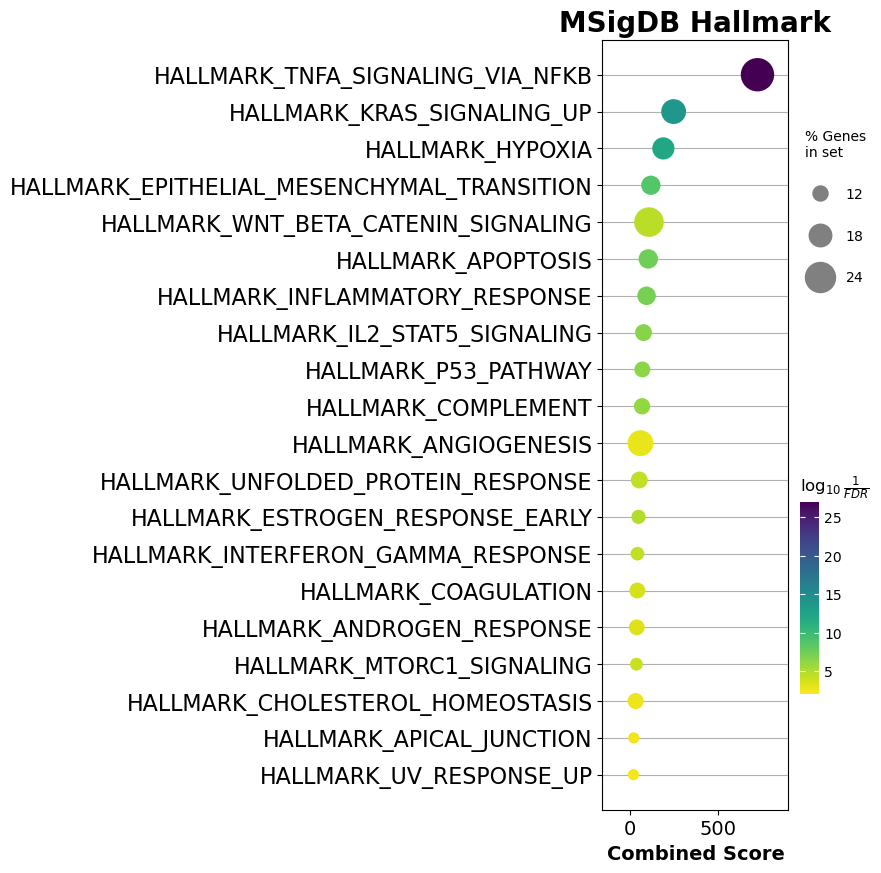

In [42]:
gp.dotplot(df=ora.res2d,                   
           column='Adjusted P-value',                   
           x='Combined Score',
           y='Term',
           top_term=20,
           cutoff=0.05,
           size=15,                   
           figsize=(3,10),                   
           title = 'MSigDB Hallmark',                  
           xticklabels_rot=0, 
           show_ring=False,              
           marker='o',
           ofname=None
          );

<h3>Exercise: Try out different arguments for the dot plot</h3>

You can also try playing around with changing the <code>x</code> and <code>column</code> parameters to see how your dot plot changes.

Also try to play around with your abritrary cut-offs to see how it affects the results you get from your over-representation analysis.

If you want, you can also plot multiple databases at once, but you'll need to first re-run the over-representation analysis with additional databases.

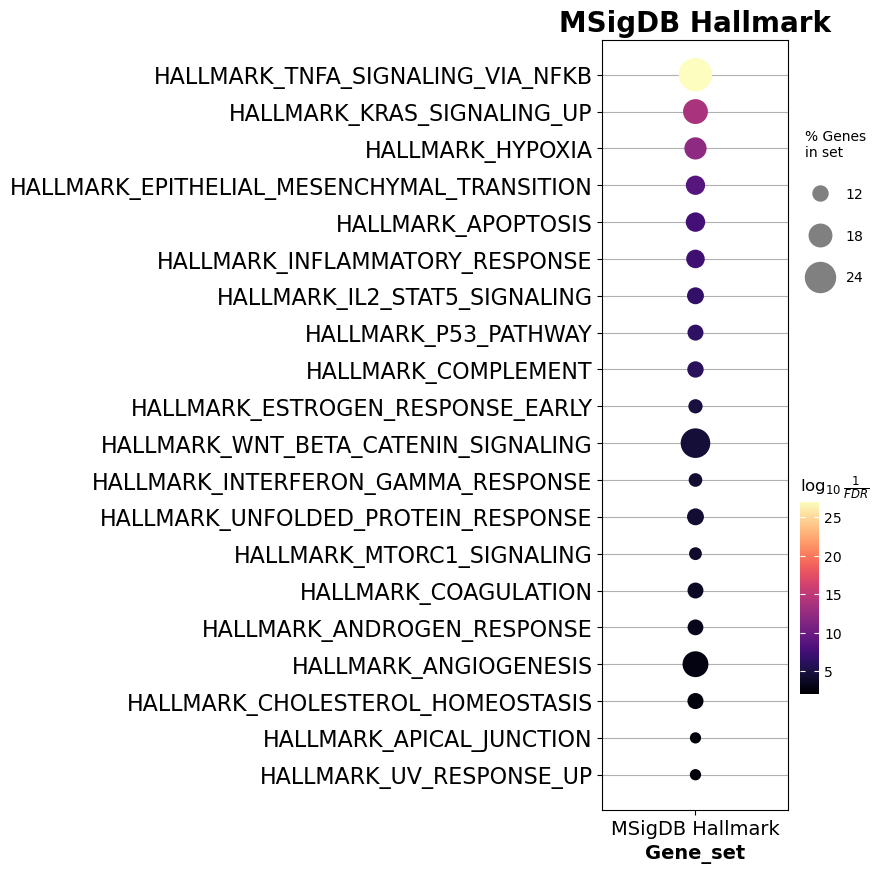

In [29]:
gp.dotplot(df=ora.res2d,                   
           column='Adjusted P-value',                   
           x='Gene_set',
           y='Term',
           top_term=20,
           cutoff=0.05,
           size=15,                   
           figsize=(3,10),                   
           title = 'MSigDB Hallmark',                  
           xticklabels_rot=0, 
           show_ring=False,              
           marker='o',
           ofname=None,
           cmap='magma'
          );

<h2>Plot a bar plot</h2>

Another way of visualizing our results is to generate a bar plot, which is a more focused graph, where we simply plot one of the result scores. We'll make use of GSEApy's <code>gp.barplot()</code> function. <a href="https://gseapy.readthedocs.io/en/latest/run.html#gseapy.plot.barplot" rel="noopener noreferrer" target="_blank"><u>Documentation is here.</u></a>


```
gp.barplot(df=ora.res2d,
           column='Combined Score',
           size=10,
           top_term=20,
           figsize=(4,7),
           title='MSigDB Hallmark',
           color='#E64B35',
           ofname=None
          );
```

The setup is very similar to the dot plot and in some ways a little simpler. The only difference here is that we can provide the function with a <code>color</code> string or dictionary that sets the fill color of the bars. If we have multiple databases being compared, we can provide it with a dictionary containing key:value pairs corresponding to the database name and the color, respectively.

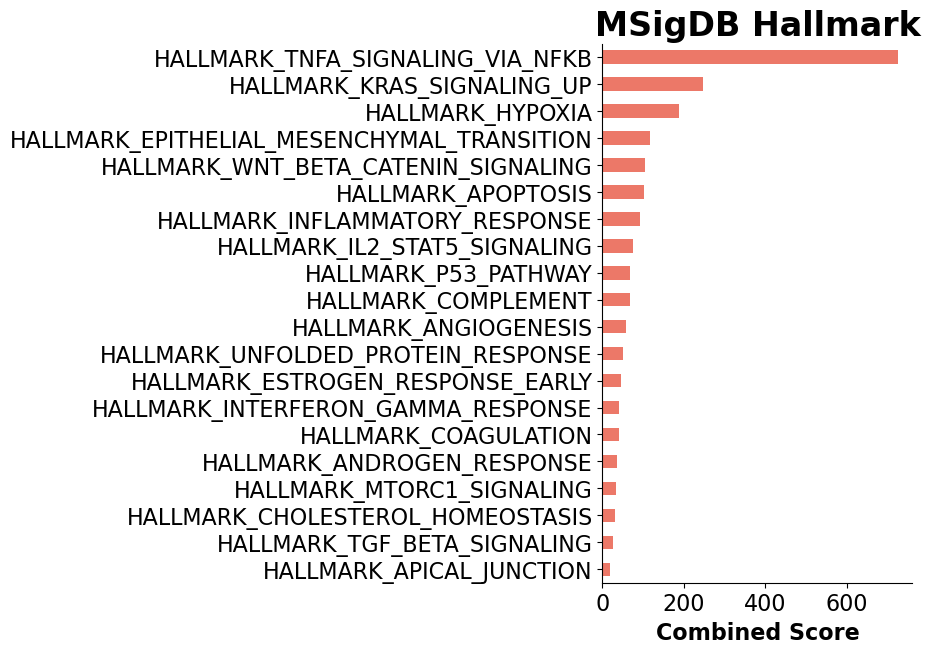

In [30]:
gp.barplot(df=ora.res2d,
           column='Combined Score',
           top_term=20,
           figsize=(4,7),
           title='MSigDB Hallmark',
           color='#E64B35',
           ofname=None
          );

<h2>Plot a volcano plot</h2>

Like with our DESeq2 results, we can also generate a volcano plot of our data. Instead of our X-axis being the log2 fold change, we'll plot the odds ratio along the X-axis.

In [31]:
interesting = ora.res2d.loc[ora.res2d['Adjusted P-value'] <= 0.05,]

<Axes: xlabel='Odds Ratio', ylabel='Adjusted P-value'>

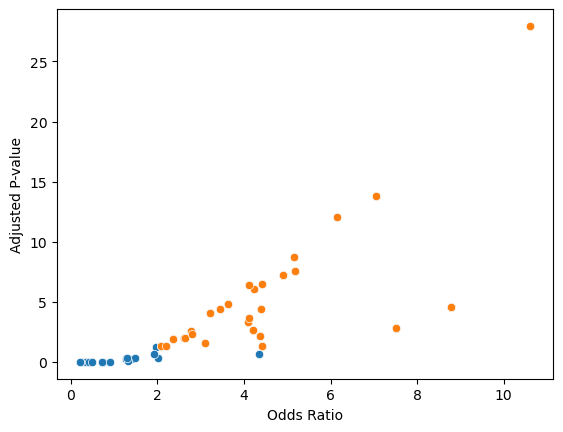

In [32]:
sns.scatterplot(x=ora.res2d['Odds Ratio'],
                y=np.log10(ora.res2d['Adjusted P-value']**-1)
               )

sns.scatterplot(x=interesting['Odds Ratio'],
                y=np.log10(interesting['Adjusted P-value']**-1)
               )

<h1>Gene Set Enrichment Analysis (GSEA)</h1>

Another common functional analysis approach is to perform a <a href="https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideFrame.html" rel="noopener noreferrer" target="_blank"><u>Gene Set Enrichment Analysis (GSEA)</u></a>. A key difference between the over-representation analysis that we performed above and GSEA is that we will take our counts matrix to perform this analysis. So we are not setting any arbitrary cutoffs for significance or log2 fold change. We provide the analysis with our expression matrix, the database that we want it to use for analysis, and metadata contained within a .cls file.

Our dataset will get ordered based on the normalized count matrix. Then the function will perform a walk down the list of genes to determine if there is an enrichment of genes within a gene set above what it would normally expect to encounter based on random chance, where random chance is determined by reshuffling (permutation) the order of the genes and repeating the walk up to a specified number of permutations. The result is that we identify which gene sets are enriched in either our control samples or our TAZ KO samples.

<h2>Perform GSEA</h2>

To perform our analysis, we'll first generate the "metadata" that will be parsed from a .cls file. The <code>gp.parser.gsea_cls_parser()</code> function will pull out the conditions and how they should be assigned to each column of your normalized counts matrix. We can generate this ourselves directly in this notebook:

We can create variables that specify what our two sample groups are:

In [33]:
ctrl = 'CONTROL'
tazko = 'TAZ KO'

Then we can put them together into a list that will be used to assign the groups to each column of our normalized count matrix:

In [34]:
([ctrl] + [tazko])*8

['CONTROL',
 'TAZ KO',
 'CONTROL',
 'TAZ KO',
 'CONTROL',
 'TAZ KO',
 'CONTROL',
 'TAZ KO',
 'CONTROL',
 'TAZ KO',
 'CONTROL',
 'TAZ KO',
 'CONTROL',
 'TAZ KO',
 'CONTROL',
 'TAZ KO']

In [35]:
class_vector = ([ctrl] + [tazko])*8

Let's take a look at the variables:

In [36]:
print(ctrl)
print(tazko)
print(class_vector)

CONTROL
TAZ KO
['CONTROL', 'TAZ KO', 'CONTROL', 'TAZ KO', 'CONTROL', 'TAZ KO', 'CONTROL', 'TAZ KO', 'CONTROL', 'TAZ KO', 'CONTROL', 'TAZ KO', 'CONTROL', 'TAZ KO', 'CONTROL', 'TAZ KO']


So this is much the same as what we did when we provided DESeq2 with a conditions matrix.

Now, we can set up and then run GSEA:

```
gs_res = gp.GSEA(data=norm_counts,
                 gene_sets=hallmark_db,
                 classes=class_vector,
                 method='signal_to_noise',
                 permutation_type='gene_set',
                 permutation_num=1000,
                 outdir=None,
                 seed=135
                )

gs_res.pheno_pos = tazko
gs_res.pheno_neg = ctrl

gs_res.run()
```

Let's break down this code block:

<code>gs_res</code>

This will be the variable to hold our GSEA results.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&equals;</code>

Our assignment variable.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>gp.GSEA()</code>

This is the function to set up our GSEA run. This set up allows us to first provide the information for our analysis before running the analysis. If we wanted to just run the analysis directly, we can instead use the <code>gp.gsea()</code> function. This will become more apparent when we specify how we want our groups to be arranged.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>data=norm_counts</code>

This is our normalized counts matrix that we'll pass to <code>gp.GSEA()</code>. We don't need to provide it with an ordered list of genes since it will perform the ranking according to the argument we set for the <code>method</code> parameter. 

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>gene_sets=hallmark_db</code>

Like with before, we indicate which database we want it to use for functional analysis. Here, we provide it with the <code>dict</code> object containing the gene sets for the MSigDB Hallmark database that we pulled in earlier.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>classes=class_vector</code>

This argument assigns the sample conditions (phenotypes) to our normalized counts matrix based on the information contained in our .cls file. So by making sure that the order of our class vector matches our normalized counts matrix columns, our samples will be assigned to their correct "class" or "phenotype".

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>method='signal_to_noise'</code>

This parameter sets the ranking algorithm that will be used. This method calculates the difference of means scaled by the standard deviation, so that a large difference in gene expression classifies that gene as a stronger "class marker" for the condition. So if something is highly upregulated in our TAZ KO samples compared to control, then it will be highly ranked in our ranked list. As we then progress towards the end of the ranked list, the genes will be highly downregulatd in TAZ KO samples compared to control, so those genes will be a stronger "class marker" for our control condition.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>permutation_type='phenotype'</code>

Recall from Dr. Ingolia's lecture that GSEA compares the enrichment relative to what would be expected by random chance. In order to determine "what would be expected by random chance", GSEA will randomly shuffle the data and repeat the analysis many times. The repeated reshuffling and "walk" down the list creates a reference for the level of enrichment that would be expected based on random chance. There are two methods to "shuffle" the data prior to analysis. 

The one discussed in lecture is a reshuffling of the sample condition prior to ranking and then repeating the walk down the list of genes. With the setup that we have indicated here with the <code>'phenotype'</code> argument, we randomly assign a condition (phenotype) to each sample, then the genes are ranked according to our specified method. Then the walk down the list is performed. This type of permutation ensures that the gene sets are constant between permutations, and by shuffling the assigned phenotypes for each of our samples, it creates a reference point for the level of enrichment when there is no differential expression in our data (a random ranking of genes). This permutation method requires that we have at least 7 samples for each condition, which we do. The stringency of this method allows us to use a cutoff FDR (q-value) of 0.25 rather than 0.05.

Another permutation method, which is less stringent, is to hold the gene rankings constant (assume the differential expression is true) and then instead reshuffle what genes are contained in the gene sets. This method can be used by passing the <code>'gene_set'</code> argument. So the reference point in this case is not a random ranking of genes but rather comparing the enrichment level to a hypothetical randomly generated gene set. This can be used if the sample numbers are too small for the 'phenotype' permutation, and it requires a FDR (q-value) cutoff of 0.05.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>permutation_num=1000</code>

This is the number of times we want to reshuffle and repeat the analysis to determine a reference enrichment level for "random chance".

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>outdir=None</code>

If we wanted to save the output into a file, we can specify the file name here.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>seed=135</code>

This seed is for the random permutations, and by setting a "seed" value, we fix the randomization, allowing our results to be reproducible between runs. So if you provided someone else with the same settings, they'll be able to get the same results if they use the same "seed" value. However, if they run with a different seed value, their randomization will be different, so their reference enrichment level will be different as well. So they may have slightly different results.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>gs_res.pheno_pos = tazko</code>

This sets which condition (phenotype) positive enrichment values are correlated with. Our setup will set positive values to be indicative of enrichment in TAZ KO samples.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>gs_res.pheno_neg = ctrl</code>

This sets which condition (phenotpe) negative enrichment values are correlated with. Based on our setup, negative values would indicate enrichment in our control samples.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>gs_res.run()</code>

After we've set up how we want to run our GSEA, we can then run the analysis with this line.

In [37]:
gs_res = gp.GSEA(data=norm_counts,
                 gene_sets=hallmark_db,
                 classes=class_vector,
                 method='signal_to_noise',
                 permutation_type='phenotype',
                 permutation_num=1000,
                 outdir=None,
                 seed=135
                )

gs_res.pheno_pos = tazko
gs_res.pheno_neg = ctrl

gs_res.run()

Let's take a look at the results table:

In [38]:
gs_res.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,HALLMARK_E2F_TARGETS,0.550269,2.156987,0.0,0.0,0.0,96/199,18.46%,NUP205;SRSF1;EIF2S1;DEK;TACC3;DLGAP5;LBR;SPAG5...
1,gsea,HALLMARK_KRAS_SIGNALING_UP,-0.575148,-2.126728,0.0,0.0,0.0,84/166,20.06%,PLAT;ITGA2;IL1B;DUSP6;PLAU;ETS1;CTSS;ALDH1A3;E...
2,gsea,HALLMARK_TNFA_SIGNALING_VIA_NFKB,-0.696692,-2.110097,0.0,0.0,0.0,112/191,14.09%,IER2;SAT1;IL1B;LAMB3;SQSTM1;PLAU;JAG1;JUN;KYNU...
3,gsea,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,-0.432591,-2.074823,0.003846,0.001806,0.004,46/111,20.73%,ATF4;PSAT1;VEGFA;HYOU1;CHAC1;TSPYL2;CEBPB;EIF4...
4,gsea,HALLMARK_COMPLEMENT,-0.439871,-2.025579,0.0,0.001626,0.005,78/168,34.45%,PLAT;SH2B3;DUSP6;CASP4;CTSS;TFPI2;KYNU;CXCL1;P...
5,gsea,HALLMARK_MYC_TARGETS_V1,0.557625,2.02173,0.001931,0.003667,0.006,108/198,18.71%,HSPD1;EIF4H;SRSF1;EIF2S1;CCNA2;TYMS;DEK;PGK1;M...
6,gsea,HALLMARK_P53_PATHWAY,-0.39137,-1.95521,0.0,0.003685,0.011,91/188,38.26%,SAT1;JUN;EPHA2;RAP2B;LIF;HBEGF;CDKN1A;TSC22D1;...
7,gsea,HALLMARK_INFLAMMATORY_RESPONSE,-0.507086,-1.949464,0.0,0.003251,0.011,67/155,22.72%,CSF3;IL1B;TPBG;NLRP3;ADORA2B;LIF;HBEGF;CDKN1A;...
8,gsea,HALLMARK_TGF_BETA_SIGNALING,-0.474414,-1.947216,0.0,0.002787,0.011,21/53,25.17%,WWTR1;NCOR2;SLC20A1;JUNB;BCAR3;PPP1R15A;KLF10;...
9,gsea,HALLMARK_APOPTOSIS,-0.412614,-1.940435,0.001961,0.002574,0.012,67/148,23.28%,PLAT;SAT1;IL1B;TIMP3;SQSTM1;CASP4;JUN;EMP1;PDC...


Depending on what seed you chose, your results might differ slightly, but we can see enrichment for a number of pathways in our TAZ KO samples. 

<h2>Generate a GSEA plot</h2>

We can then visualize our results with a GSEA plot:

```
fig = gs._res.plot(gs_res.res2d.Term[0])
```

This function will generate a GSEA plot for our indicated gene set term/category, and the object is a matplotlib.Figure object, which we can modify using the same methods we have been using for our other figures.

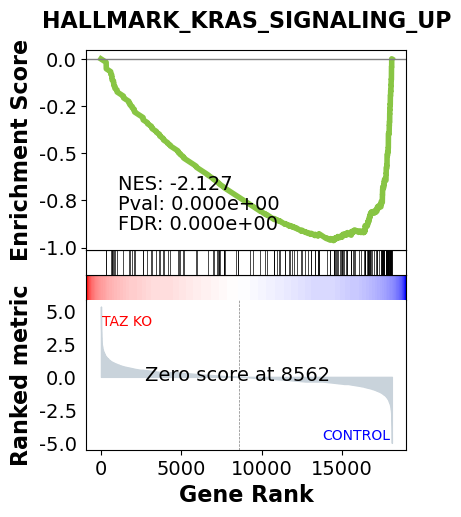

In [44]:
fig = gs_res.plot(gs_res.res2d.Term[1])

fig.set_size_inches(4,5)

If we want to plot multiple GSEA plots (say of our top 5 hits), we can make use of a for loop:

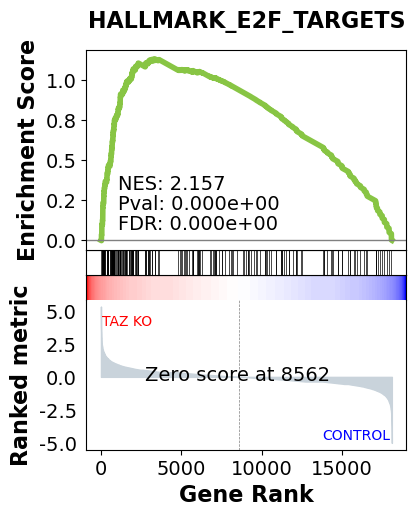

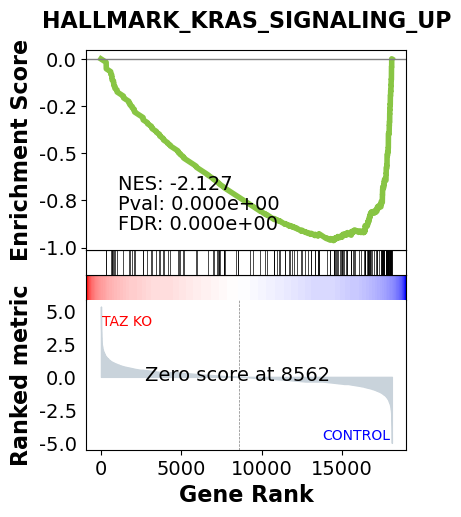

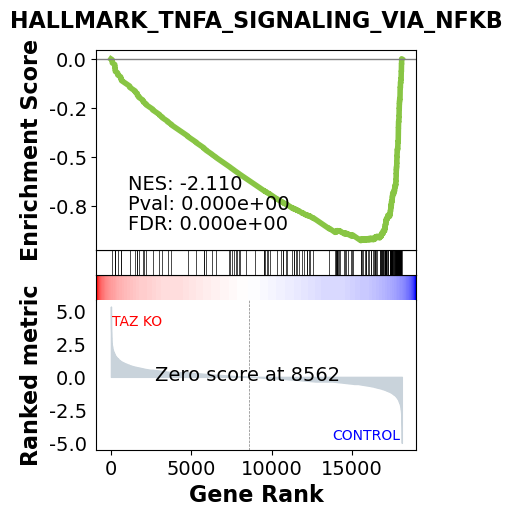

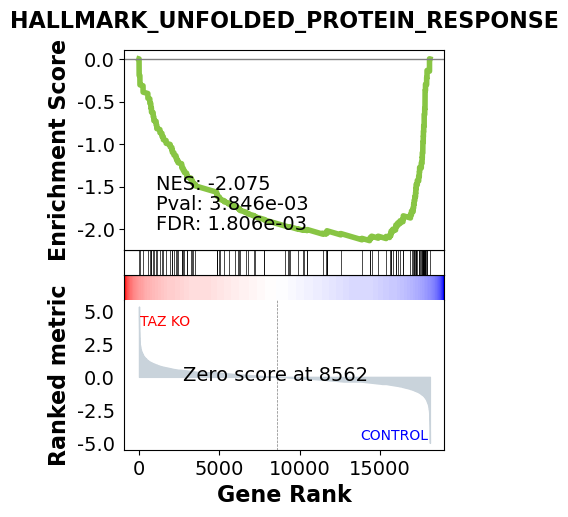

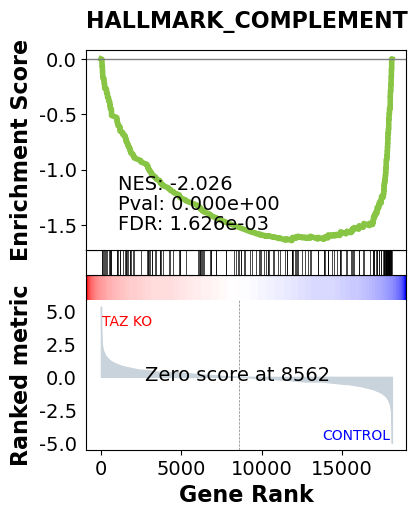

In [40]:
for i in np.arange(0, 5, 1):
    fig = gs_res.plot(gs_res.res2d.Term[i])
    fig.set_size_inches(4,5)

Another way of looking at multiple GSEA terms is to plot them all together onto a single GSEA plot. We'll use the same function as before but instead of providing it with a single term, we can provide a list of terms:

```
gs_res.plot(gs_res.res2d.Term[:5])
```

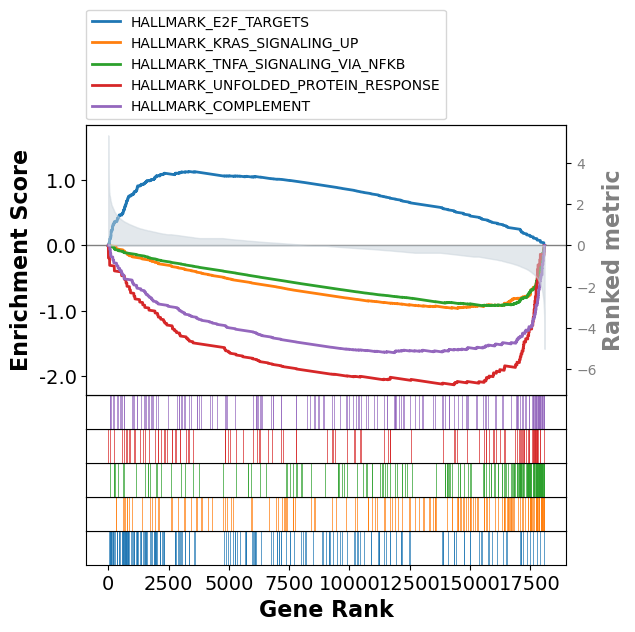

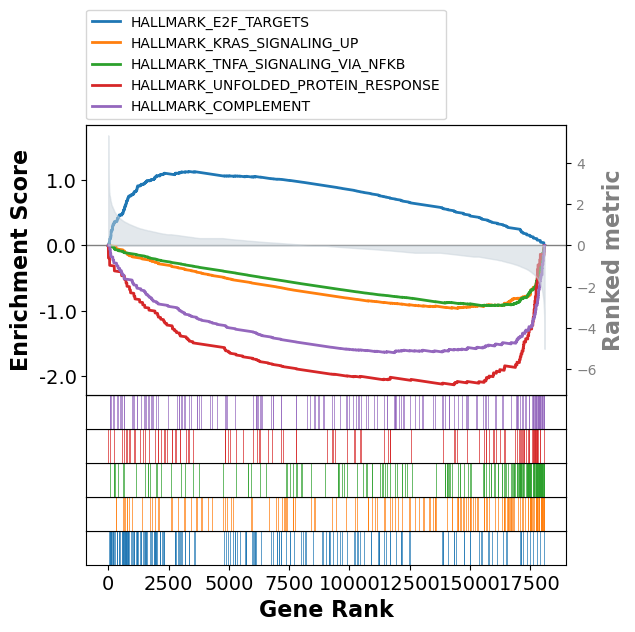

In [45]:
gs_res.plot(gs_res.res2d.Term[:5])

<h2>Generate heatmap of leading edge genes</h2>

The leading edge of a GSEA plot are the genes that have contributed to the "peak" enrichment score of a term, and we can pull them out of our results matrix to generate a heatmap of their relative expression levels between our two conditions. To do this, we'll first need to pull out each of the genes identified as a leading edge gene for a term of interest:

```
genes = gs_res.res2d.Lead_genes[0].split(';')
```

This line of code pulls out the string containing the gene names of the leading edge genes for our top GSEA result, and since the gene names are all a single value in the data matrix separated by a semicolon, we can split them apart from each other with the <code>str.split()</code> function, where <code>str</code> is replaced with the string we want to split up into a list.

In [65]:
genes = gs_res.res2d.Lead_genes[0].split(';')

In [ ]:
genes

Let's take a look at our leading edge gene names:

In [59]:
gs_res.heatmat.loc[genes]

,taz_g1,taz_g2,taz_g3,taz_g4,taz_g5,taz_g6,taz_g7,taz_g8,ctrl_g1,ctrl_g2,ctrl_g3,ctrl_g4,ctrl_g5,ctrl_g6,ctrl_g7,ctrl_g8
gene,,,,,,,,,,,,,,,,
NUP205,191.877327,191.153888,206.792308,189.426191,227.601739,155.307239,176.081987,182.336696,87.936853,115.181709,94.803186,110.543931,111.333430,98.247524,99.765808,92.788262
SRSF1,392.346175,409.217788,362.378901,381.751763,378.112567,359.021930,363.832058,369.824146,243.061413,253.005976,282.454853,259.240191,253.540836,299.704569,298.236085,305.170285
EIF2S1,190.922713,195.793545,192.021429,227.118138,212.000007,197.663759,207.904033,201.909561,165.993160,142.746562,146.602865,160.435439,141.271831,135.958695,152.832727,149.492200
DEK,741.734740,807.300399,762.177363,893.975648,823.220806,756.366425,722.360441,770.552816,625.438513,616.271365,610.845271,628.046048,598.768025,568.644763,583.736110,534.047999
TACC3,152.738170,139.189724,155.586593,136.270883,133.991346,140.179911,140.017002,139.070361,102.757670,115.181709,106.531415,116.413520,116.011305,101.224722,117.808560,116.500818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCNE1,14.319203,20.414493,16.740330,11.597522,12.848485,14.118840,19.093228,28.844223,5.928327,9.844591,10.750877,13.695708,12.162476,22.825182,14.858737,7.216865
ORC2,42.957610,24.126219,47.266813,24.161504,45.887447,37.314077,30.761311,29.874374,28.653581,20.673640,30.297925,23.478357,33.680701,25.802380,32.901490,35.053344
GINS1,64.913722,31.549671,46.282088,43.490707,48.640694,53.449894,40.307925,40.175882,43.474399,16.735804,39.094097,43.043654,44.907602,39.695969,36.085505,38.146286


We can pass this list to an organized counts matrix generated by <code>gp.GSEA()</code> and contained within the output <code>gs_res</code> object.

```
gp.heatmap(df=gs_res.heatmat.loc[genes], 
           z_score=0, 
           title=gs_res.res2d.Term[0], 
           figsize=(16,8), 
           cmap='viridis'
          );
```

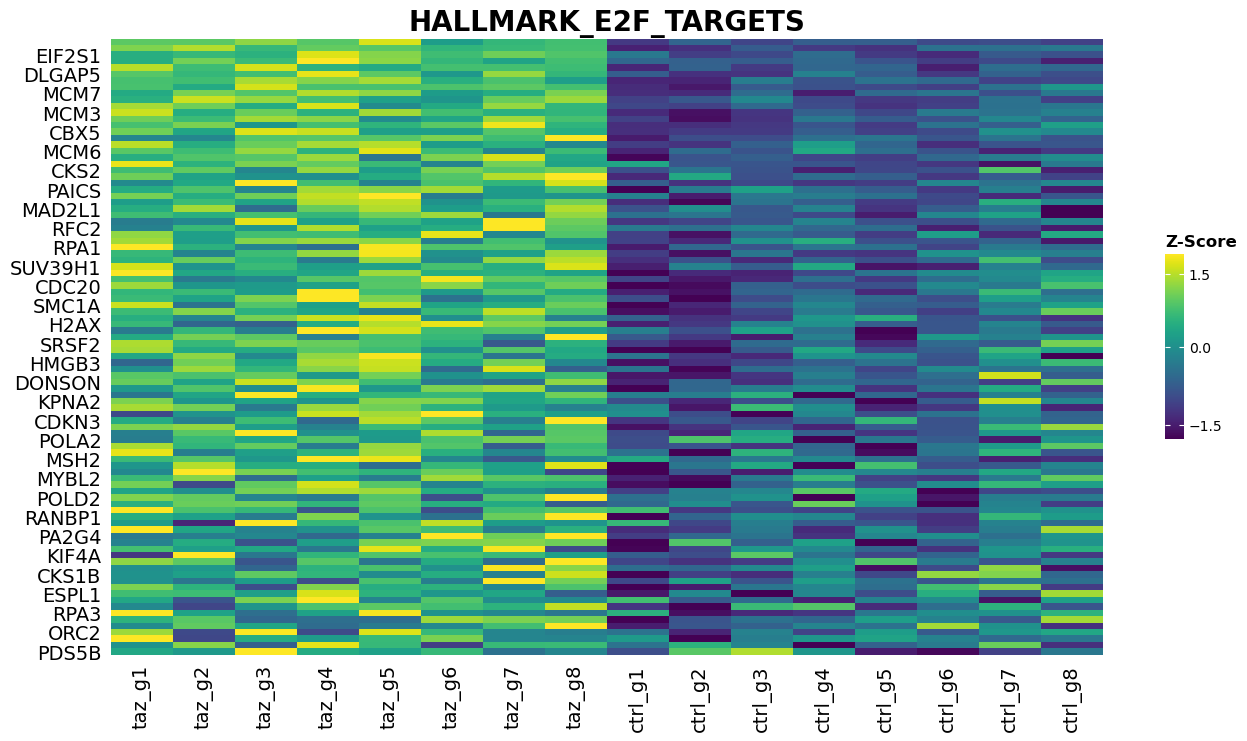

In [66]:
gp.heatmap(df=gs_res.heatmat.loc[genes],
           z_score=0,
           title=gs_res.res2d.Term[0],
           figsize=(16,8),
           cmap='viridis'
          );

Like with our GSEA plots, if we want to plot our top 5 terms, we can make use of a for loop:

<h2>Generate a dot plot from GSEA results</h2>

Similar to our over-representation analysis, we can also generate a dot plot from the results of our GSEA run. We'll again make use of the <code>gp.dotplot</code> function.

```
gp.dotplot(df=gs_res.res2d,             
           column="FDR q-val",
           x='NES',
           y='Term',
           top_term=30,
           cutoff=0.25,            
           size=5, 
           figsize=(3,10),
           title='MSigDB Hallmark',
           xticklabels_rot=0,
           show_ring=True,
           marker='o',
           ofname=None
          );
```

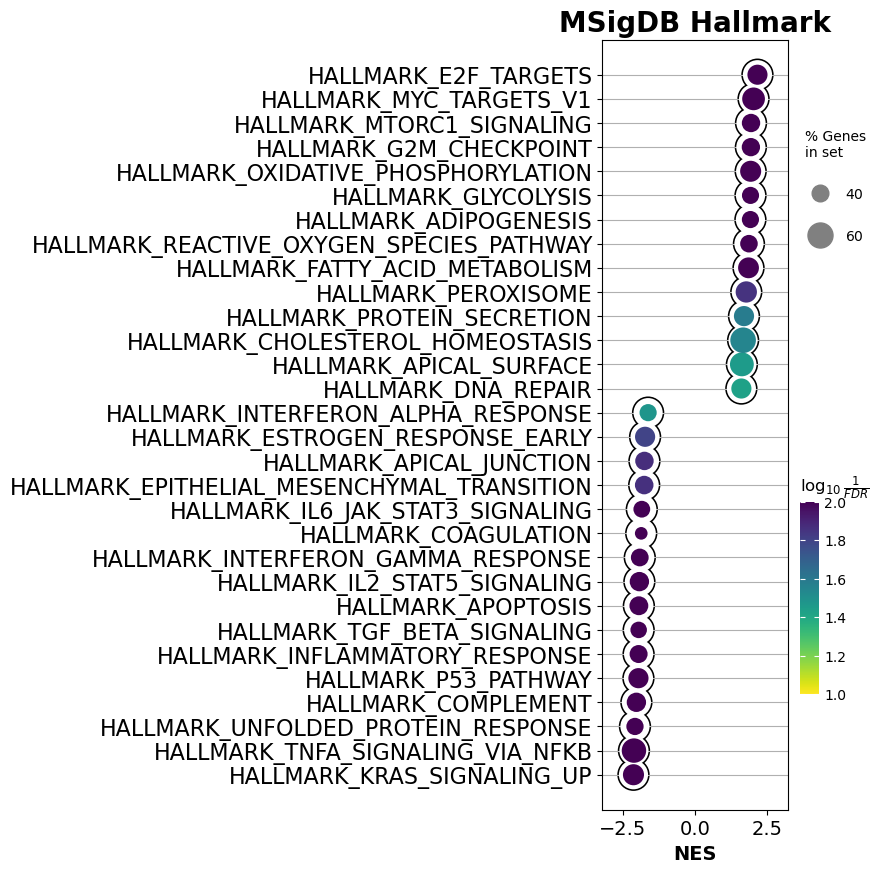

In [69]:
gp.dotplot(df=gs_res.res2d,             
           column="FDR q-val",
           x='NES',
           y='Term',
           top_term=30,
           cutoff=0.25,            
           size=5, 
           figsize=(3,10),
           title='MSigDB Hallmark',
           xticklabels_rot=0,
           show_ring=True,
           marker='o',
           ofname=None
          );

<h2>Plot an enrichment map network</h2>

We can zoom out even more to look at the connections/relationships between different enriched terms that we identified through GSEA. This can help provide us with an even higher order view of the changes resulting from our experimental manipulation by identifying related pathways or biological processes that are all changing together in our cells. In this type of network visualization, our terms form nodes in the network that are then connected to each other if they share a gene in their gene set. The strength of the connection is then visualized as the line width of the connecting line between nodes, with a greater number of shared genes pointing to a greater relationship between the two nodes. This could give us additional higher order insights into the changes occurring in our cells as a result of our KO. For example, if we find that a lot of inflammation related terms are all enriched, their overlapping genes may be of interest for further inquiry or inflammation in general. 

First we can build our network nodes and edges:

```
nodes, edges = gp.enrichment_map(gs_res.res2d, 
                                 top_term=20, 
                                 cutoff=0.25
                                )
```

In [70]:
nodes, edges = gp.enrichment_map(gs_res.res2d, 
                                 top_term=20, 
                                 cutoff=0.25
                                )

Let's take a look at how many nodes we have in our network:

In [71]:
nodes

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,p_inv,Hits_ratio
node_idx,,,,,,,,,,,,
0,gsea,HALLMARK_FATTY_ACID_METABOLISM,0.42236,1.847748,0.0,0.007844,0.044,71/142,31.78%,CPOX;ELOVL5;EPHX1;S100A10;MDH2;GPD2;PTPRG;HSP9...,2.105490,0.500000
1,gsea,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,0.560508,1.862893,0.011905,0.006990,0.034,19/45,12.88%,NQO1;G6PD;TXNRD1;GPX4;FTL;SOD1;PTPA;PRDX1;PRDX...,2.155498,0.422222
2,gsea,HALLMARK_G2M_CHECKPOINT,0.443055,1.929537,0.005871,0.006876,0.017,87/198,20.92%,HMGN2;SRSF1;CCNA2;TACC3;LBR;BUB1;MCM3;MCM5;MAP...,2.162677,0.439394
3,gsea,HALLMARK_OXIDATIVE_PHOSPHORYLATION,0.53126,1.921743,0.001969,0.005867,0.018,101/200,20.78%,ATP6V1D;MDH2;NDUFB2;ATP5MC3;GPX4;ATP5F1A;LDHA;...,2.231558,0.505000
4,gsea,HALLMARK_IL6_JAK_STAT3_SIGNALING,-0.48424,-1.838831,0.001916,0.005690,0.036,29/72,23.28%,IL1B;PTPN11;JUN;CXCL1;PIM1;CXCL3;CSF2;IL6;CCR1...,2.244886,0.402778
5,gsea,HALLMARK_GLYCOLYSIS,0.41867,1.91627,0.0,0.005653,0.019,76/185,20.57%,ENO1;COL5A1;GPC1;AK4;PKM;MDH2;G6PD;PGAM1;PGK1;...,2.247688,0.410811
6,gsea,HALLMARK_COAGULATION,-0.455459,-1.858664,0.0,0.005419,0.032,31/102,19.30%,MMP1;PLAT;ITGA2;TIMP3;DUSP6;THBD;PLAU;KLF7;TFP...,2.266075,0.303922
7,gsea,HALLMARK_ADIPOGENESIS,0.42521,1.913634,0.0,0.004846,0.019,77/187,20.13%,UCP2;TKT;DHCR7;AGPAT3;MDH2;GPD2;MYLK;GPX4;RTN3...,2.314635,0.411765
8,gsea,HALLMARK_P53_PATHWAY,-0.39137,-1.95521,0.0,0.003685,0.011,91/188,38.26%,SAT1;JUN;EPHA2;RAP2B;LIF;HBEGF;CDKN1A;TSC22D1;...,2.433566,0.484043


In [72]:
edges

,src_idx,targ_idx,src_name,targ_name,jaccard_coef,overlap_coef,overlap_genes
0,0,1,HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,0.011236,0.052632,PRDX6
1,0,2,HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_G2M_CHECKPOINT,0.006369,0.014085,H2AZ1
2,0,3,HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_OXIDATIVE_PHOSPHORYLATION,0.088608,0.197183,"ECHS1,LDHA,SDHA,SDHD,SDHC,DLST,PDHB,DLD,IDH3G,..."
3,0,5,HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_GLYCOLYSIS,0.065217,0.126761,"LDHA,NSDHL,ME1,SDHC,MIF,DLD,MDH2,IDH1,MDH1"
4,0,7,HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_ADIPOGENESIS,0.072464,0.140845,"ECHS1,HADH,ME1,SDHC,DLD,GPD2,IDH3G,CRAT,MDH2,IDH1"
...,...,...,...,...,...,...,...
79,15,16,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_COMPLEMENT,0.016393,0.043478,"CEBPB,HSPA5"
80,15,17,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.025974,0.086957,"VEGFA,ATF3,CCL2,CEBPB"
81,16,17,HALLMARK_COMPLEMENT,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.067416,0.153846,"SERPINB2,CEBPB,PLAUR,CCL5,TNFAIP3,IRF1,SERPINE..."
82,16,18,HALLMARK_COMPLEMENT,HALLMARK_KRAS_SIGNALING_UP,0.038462,0.076923,"DUSP6,TNFAIP3,PLAUR,CFH,PLAT,CTSS"


Then we can use the networkx package to create our network visualization:

```
G = nx.from_pandas_edgelist(edges,
                            source='src_idx',
                            target='targ_idx',
                            edge_attr=['jaccard_coef', 'overlap_coef']
                           )
```

This sets up the vectors that define the edges between nodes for our network, and we can then pull the edge attributes later to visualize the strength of the relationship between our nodes. We can select from:

<ul>
    <li>the Jaccard coefficient <code>'jaccard_coef'</code> which measures the similarity and diversity of two connected gene sets</li>
    <li>the overlap coefficient <code>'overlap_coef'</code> which measures the similarity between two connected gene sets</li>
</ul>

In [73]:
G = nx.from_pandas_edgelist(edges,
                            source='src_idx',
                            target='targ_idx',
                            edge_attr=['jaccard_coef', 'overlap_coef']
                           )

Once we've generated our edges, we can then check to see if all our nodes are connected with one another, otherwise there will be an error later on if we have an orphan node when plotting our network:

In [77]:
G.nodes

NodeView((0, 1, 2, 3, 5, 7, 9, 19, 4, 6, 8, 10, 11, 12, 14, 16, 17, 18, 13, 15))

In [78]:
for id in nodes.index:
    if id in G.nodes:
        print(f'Node #{id} exists')
    else:
        print(f'Node #{id} not here...')

Node #0 exists
Node #1 exists
Node #2 exists
Node #3 exists
Node #4 exists
Node #5 exists
Node #6 exists
Node #7 exists
Node #8 exists
Node #9 exists
Node #10 exists
Node #11 exists
Node #12 exists
Node #13 exists
Node #14 exists
Node #15 exists
Node #16 exists
Node #17 exists
Node #18 exists
Node #19 exists


Now let's generate our network visualization from our nodes and edges:

```
fig, ax = plt.subplots()

pos_n=nx.layout.circular_layout(G)

nx.draw_networkx_nodes(G,
                       pos=pos_n, 
                       cmap='cool',
                       node_color=list(nodes.NES), 
                       node_size=list(nodes.Hits_ratio *1000)
                      )

nx.draw_networkx_labels(G,
                        pos=pos_n,
                        labels=nodes.Term.to_dict(),
                        font_size=6,
                        font_color='#000000'
                       )

edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()

nx.draw_networkx_edges(G,
                       pos=pos_n,
                       width=np.multiply(list(edge_weight), 15),
                       edge_color='#CCCCCC'
                      )

plt.xlim(-1.5, 1.5)
plt.ylim(-1.25, 1.25)

fig.set_size_inches(8, 6)
fig.set_dpi(300)

plt.show()
```

Breaking down this code block, we have:

```
pos_n=nx.layout.circular_layout(G)
```

This defines the positions of our nodes. Here, we set up our network map with a circular layout, so our nodes will form a circle.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

```
nx.draw_networkx_nodes(G,
                       pos=pos_n, 
                       cmap='cool',
                       node_color=list(nodes.NES), 
                       node_size=list(nodes.Hits_ratio *1000)
                      )
```

This draws the nodes onto our figure based on the layout we defined earlier, and we can specify the fill color for our nodes as well as their size and how they are determined.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

```
nx.draw_networkx_labels(G,
                        pos=pos_n,
                        labels=nodes.Term.to_dict(),
                        font_size=6,
                        font_color='#000000'
                       )
```

This sets the labels for our nodes.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

```
edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
```

Here we define the weight of our edges that will visualize the strength of the relationship between our nodes. In other words, this will show the connectedness of different terms.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

```
nx.draw_networkx_edges(G,
                       pos=pos_n,
                       width=np.multiply(list(edge_weight), 15),
                       edge_color='#CCCCCC'
                      )
```

This uses the information of our node positions and the <code>edge_weight</code> to draw our edge vectors.

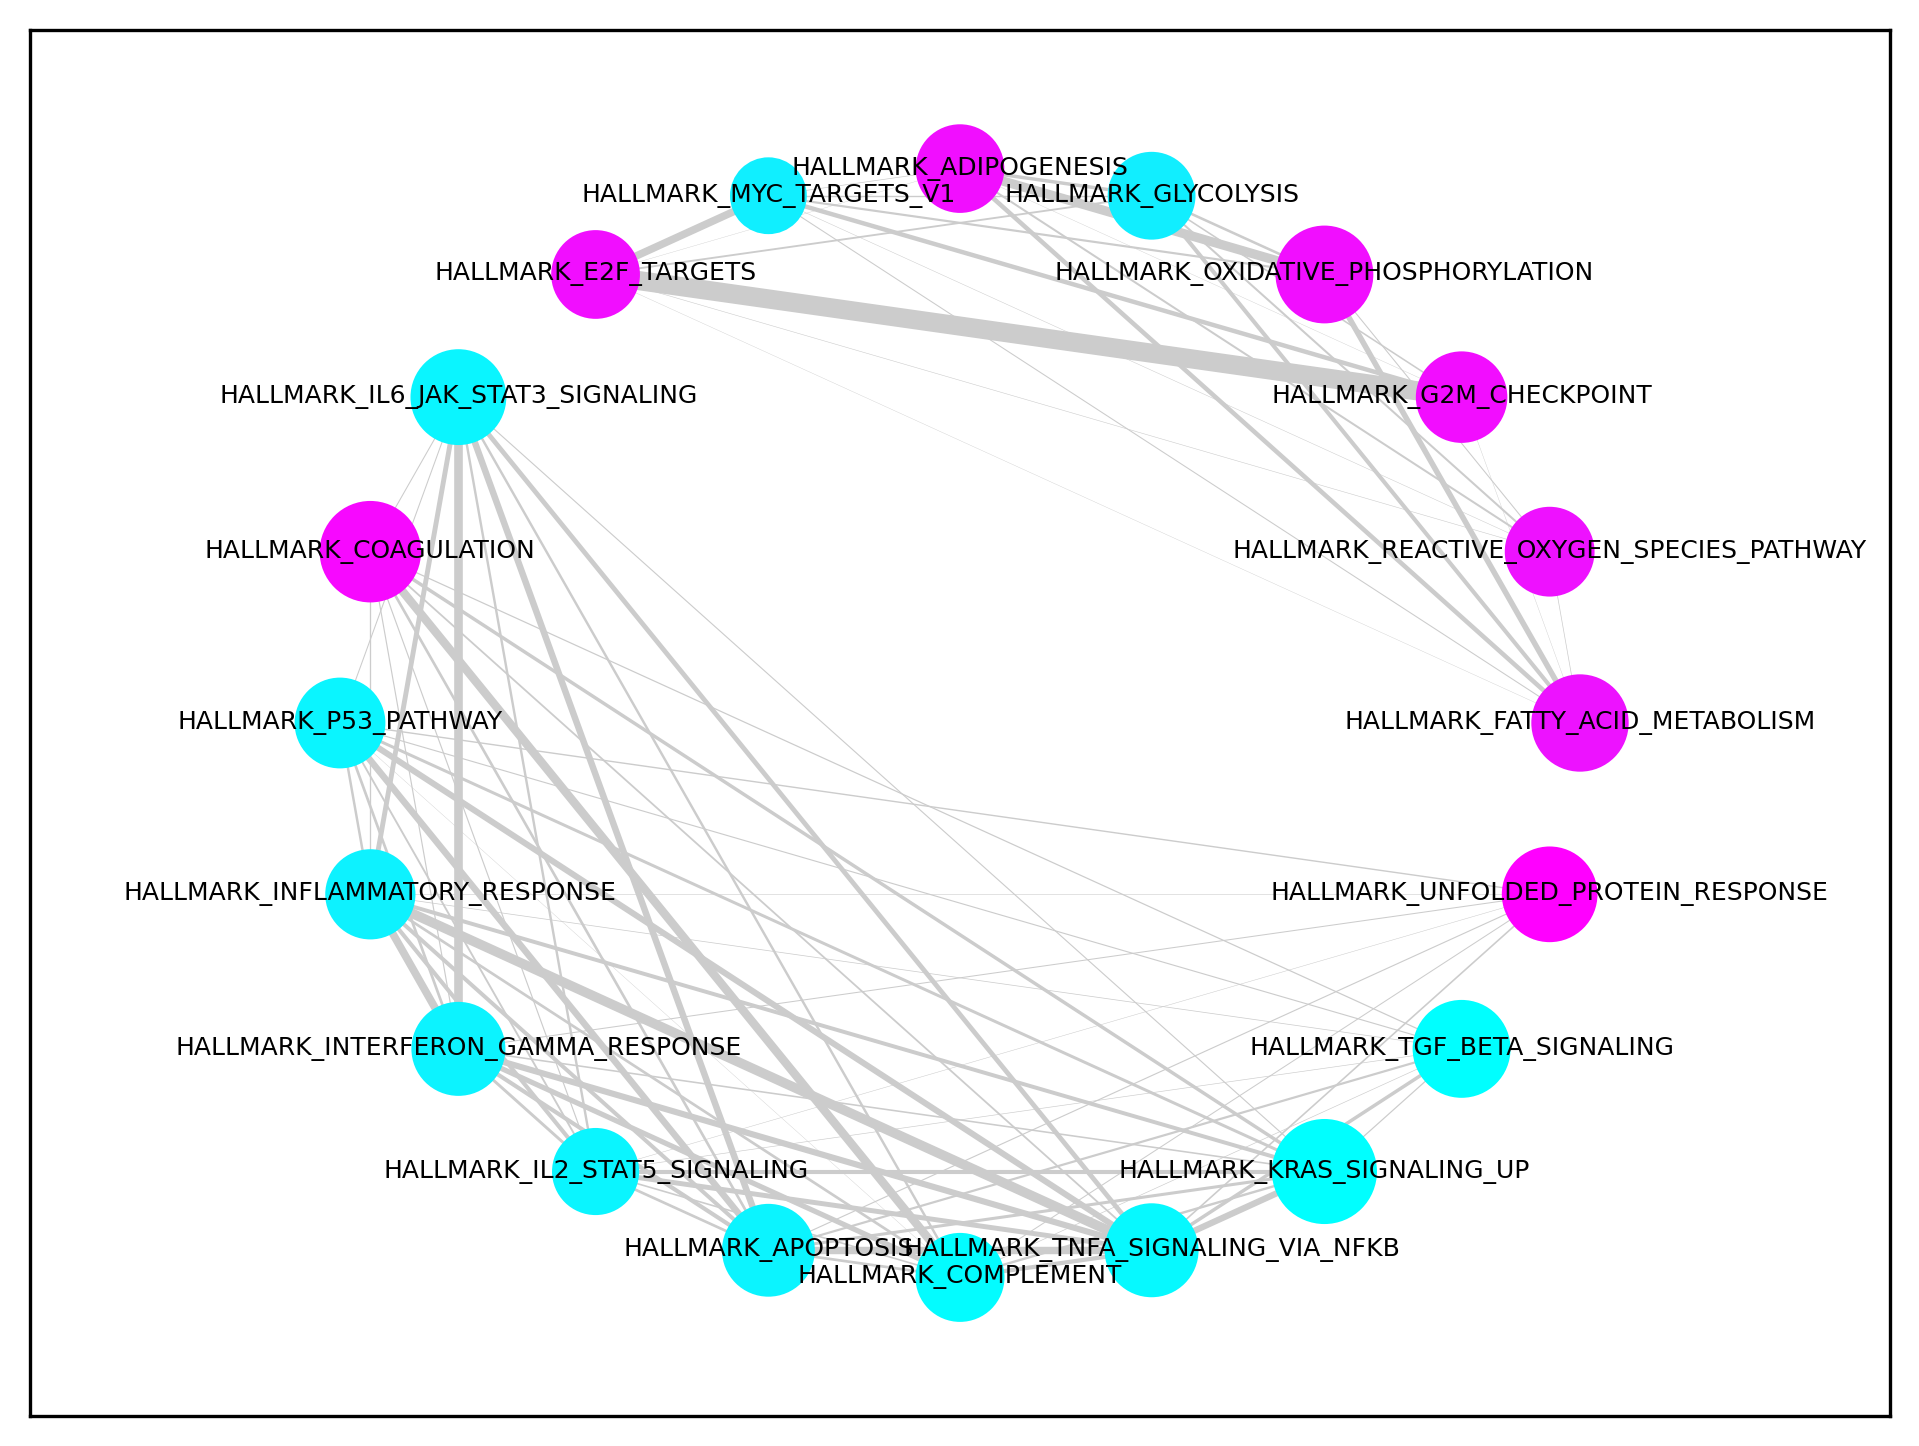

In [82]:
fig, ax = plt.subplots()

pos_n=nx.layout.circular_layout(G)

nx.draw_networkx_nodes(G,
                       pos=pos_n, 
                       cmap='cool',
                       node_color=list(nodes.NES), 
                       node_size=list(nodes.Hits_ratio *1000)
                      )

nx.draw_networkx_labels(G,
                        pos=pos_n,
                        labels=nodes.Term.to_dict(),
                        font_size=6,
                        font_color='#000000'
                       )

edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()

nx.draw_networkx_edges(G,
                       pos=pos_n,
                       width=np.multiply(list(edge_weight), 15),
                       edge_color='#CCCCCC'
                      )

plt.xlim(-1.5, 1.5)
plt.ylim(-1.25, 1.25)

fig.set_size_inches(8, 6)
fig.set_dpi(300)

plt.show()

<h1>Exploring other functional analysis programs</h1>

There are a number of available free programs to use for functional analysis. A large number of them are web-based but some can also be downloaded and run on your computer. As you've seen today, you can run functional analysis in Python, but you can also run functional analysis in R. Some of them are included below if you want to explore them:

Enrichr - https://maayanlab.cloud/Enrichr/

gProfiler - https://biit.cs.ut.ee/gprofiler/gost

Panther - https://pantherdb.org/

GOrilla - https://cbl-gorilla.cs.technion.ac.il/

Ontologizer - http://ontologizer.de/

Gene Weaver - https://www.geneweaver.org/

ClueGO - https://apps.cytoscape.org/apps/cluego

DAVID - https://davidbioinformatics.nih.gov/content.jsp?file=functional_annotation.html

GSEA desktop application - https://www.gsea-msigdb.org/gsea/index.jsp

clusterProfiler (in R)


<h1 style="font-size: 40px; margin-bottom: 0px;">References</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 400px;"></hr>

<a href="https://academic.oup.com/bioinformatics/article/39/1/btac757/6847088" rel="noopener noreferrer" target="_blank"><u>Fang et al 2022 Bioinformatics:</u></a> GSEApy: a comprehensive package for performing gene set enrichment analysis in Python

<a href="https://www.pnas.org/doi/10.1073/pnas.0506580102" rel="noopener norferrer" target="_blank"><u>Subramanian, Tamayo et al 2005 PNAS:</u></a> Gene set enrichment analysis: A knowledge-based approach for interpreting genome-wide expression profiles

<a href="https://pmc.ncbi.nlm.nih.gov/articles/PMC4707969/" rel="noopener norferrer" target="_blank"><u>Liberzon et al 2015 Cell Syst:</u></a> The Molecular Signatures Database (MSigDB) hallmark gene set collection

<a href="https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-128" rel="noopener noreferrer" target="_blank"><u>Chen et al 2013 BMC Bioinformatics:</u></a> Enrichr: interactive and collaborative HTML5 gene list enrichment analysis tool